<a href="https://colab.research.google.com/github/2303A510j7/Random-forest-traffic-model/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Dataset loaded successfully!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB
None

Sample Rows:
          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         T

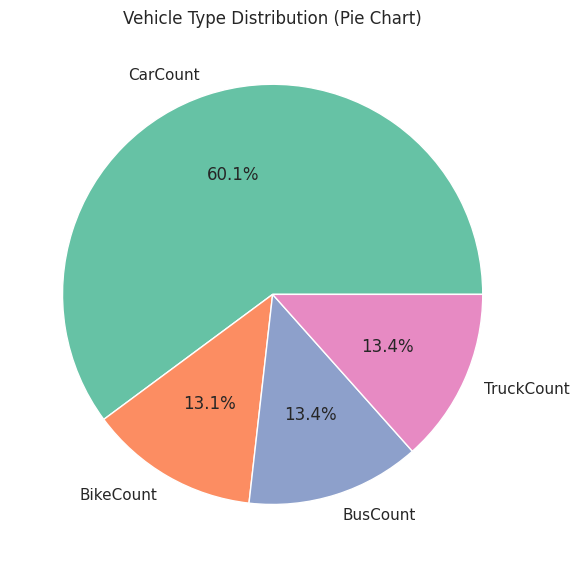

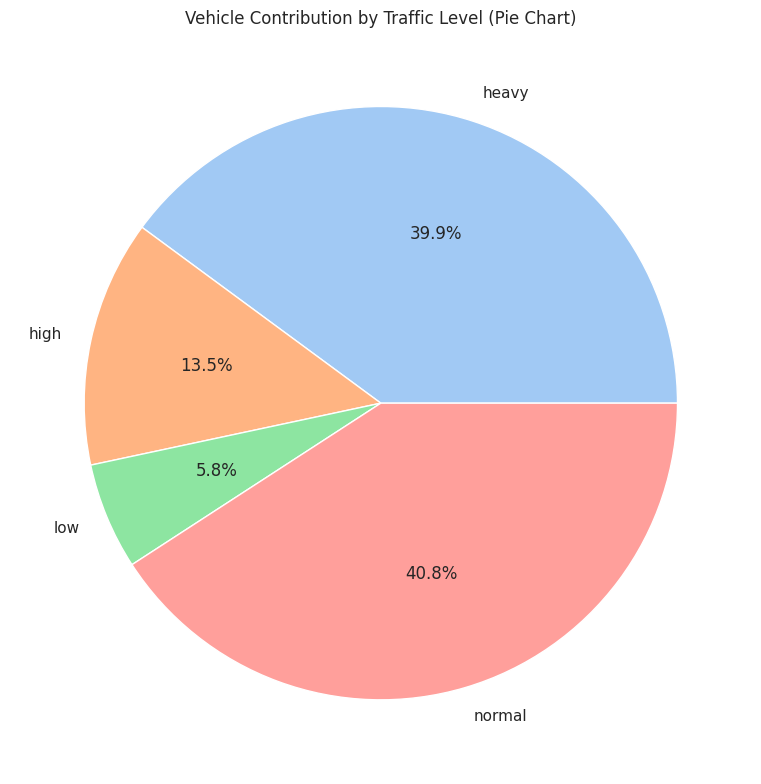

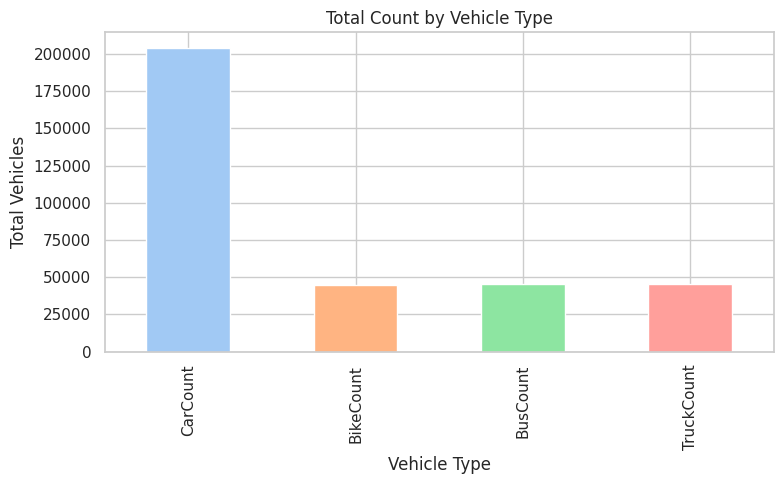

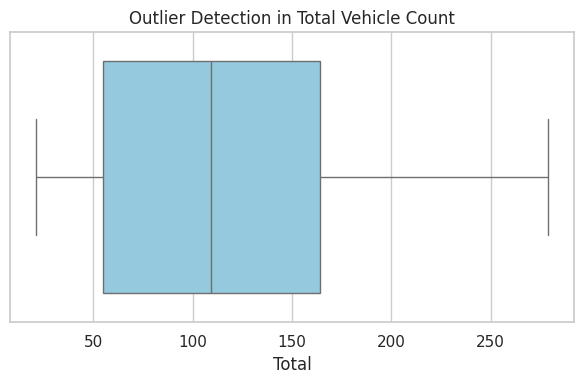

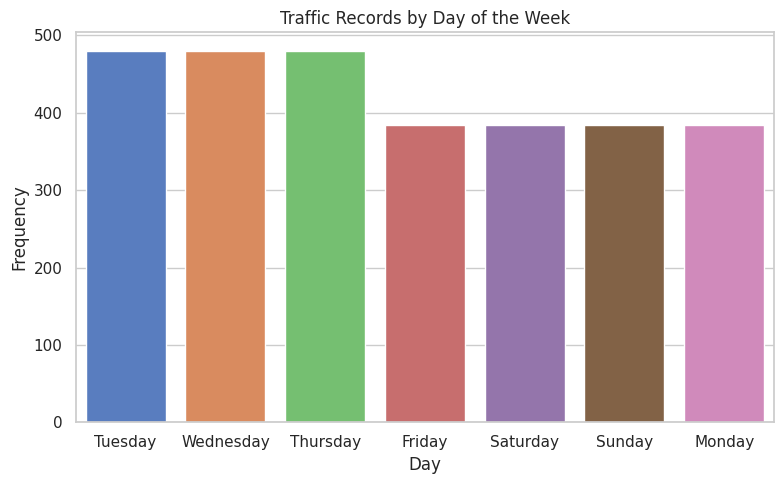

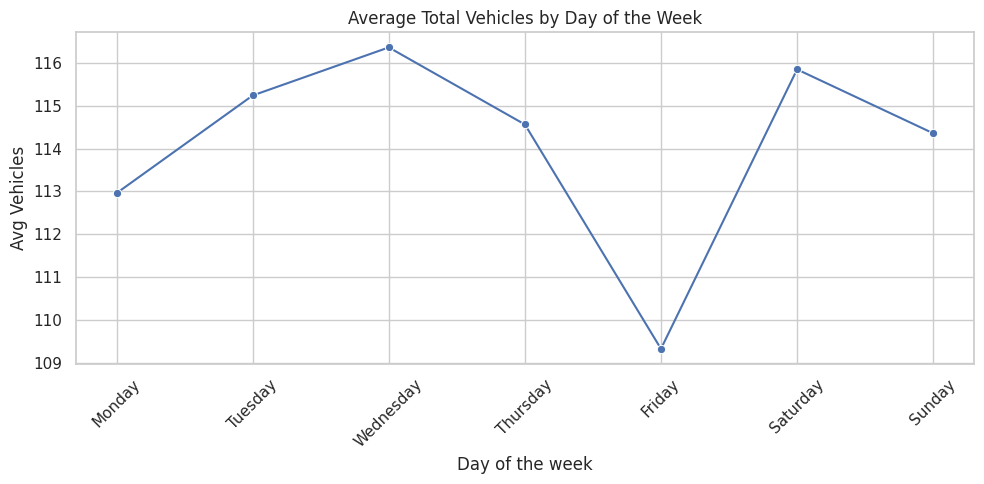

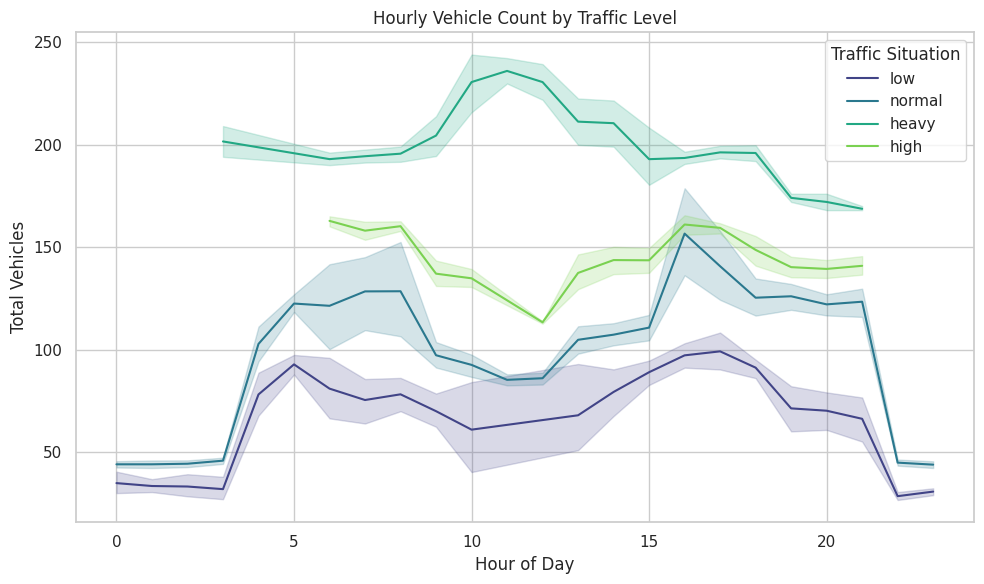

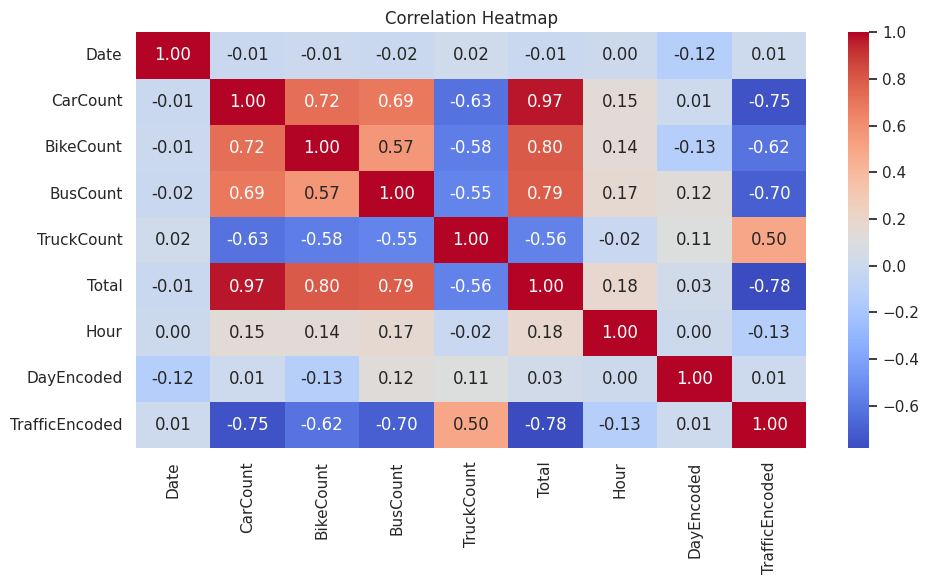

Model Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

       heavy       0.90      0.98      0.94       127
        high       0.88      0.83      0.85        63
         low       0.98      0.97      0.98        66
      normal       0.98      0.96      0.97       340

    accuracy                           0.95       596
   macro avg       0.94      0.93      0.93       596
weighted avg       0.95      0.95      0.95       596



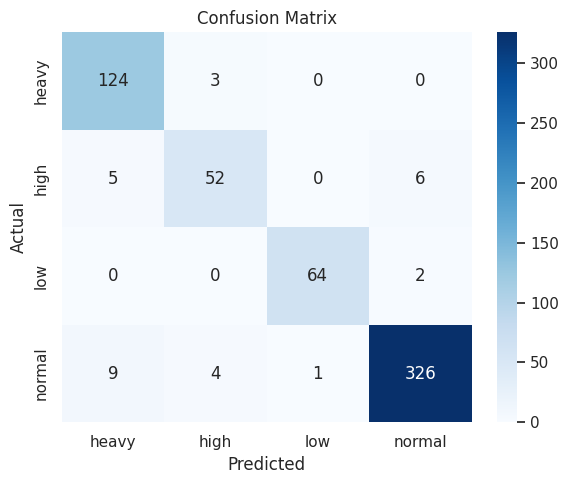

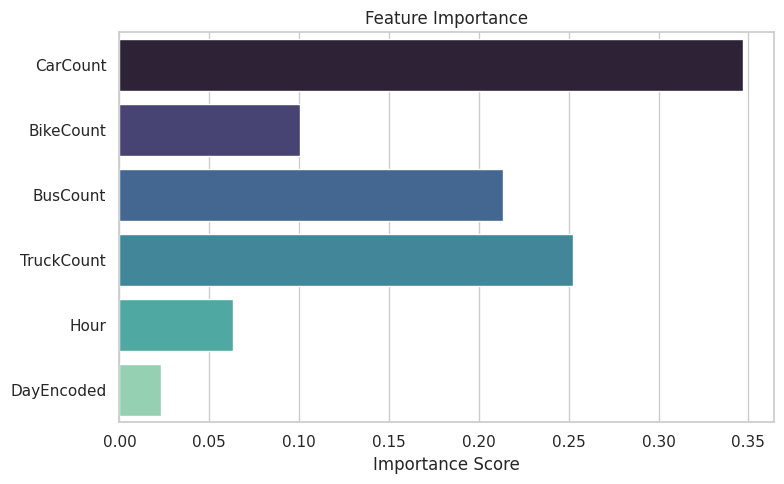


Average Vehicles During Peak Hours: 159.05
Average Vehicles During Off-Peak Hours: 99.28


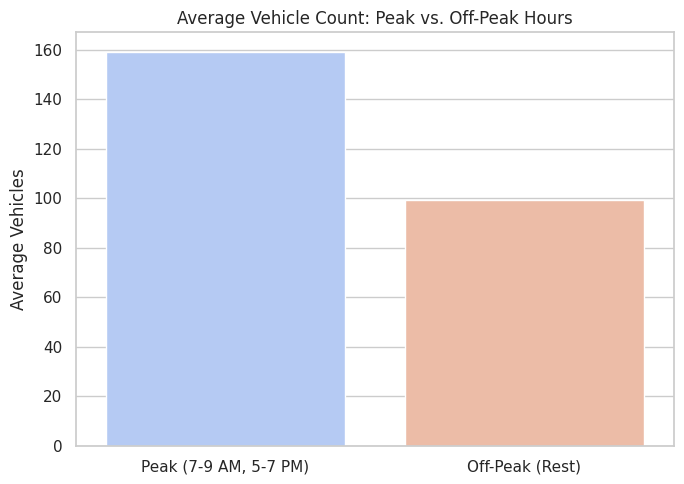

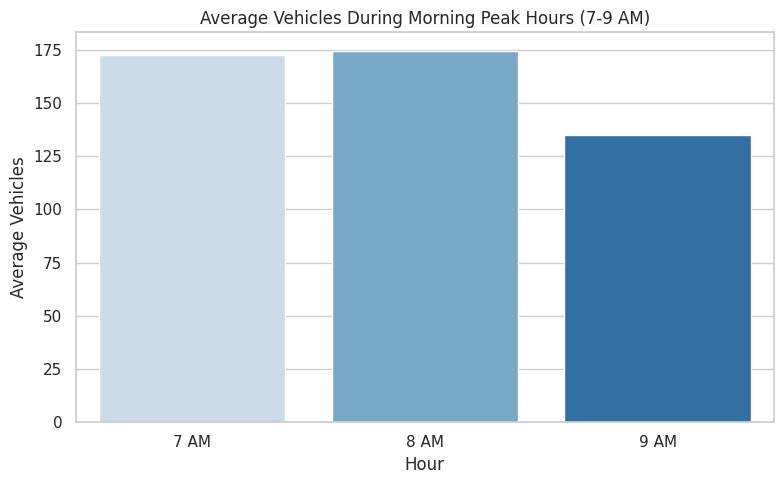


Key Observations:
1. The majority of traffic is 'Normal', with low and high traffic forming smaller proportions.
2. Morning (7-9 AM) and evening (5-7 PM) show peak congestion.
3. Car count and hour of day have the most influence on predicting traffic level.
4. The Random Forest model achieved high classification accuracy.
5. Weekly traffic and boxplots provided more detailed insights into daily trends and outliers.
6. Feature importance and confusion matrix confirmed reliability of model predictions.


In [1]:
# Intelligent Traffic Flow Prediction for Smart Cities – Enhanced & Unique Version

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Load dataset
file_path = "/content/dataset.csv"
print("Loading dataset...")
df = pd.read_csv(file_path)
print("Dataset loaded successfully!\n")

# Show dataset structure and sample data
print("Dataset Info:")
print(df.info())
print("\nSample Rows:")
print(df.head())

# Convert 'Time' to hour format
print("\nProcessing time column...")
df['Hour'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.hour

# Encode categorical features
day_encoder = LabelEncoder()
df['DayEncoded'] = day_encoder.fit_transform(df['Day of the week'])

traffic_encoder = LabelEncoder()
df['TrafficEncoded'] = traffic_encoder.fit_transform(df['Traffic Situation'])

# ---------------------- EXPLORATORY DATA ANALYSIS ---------------------- #

# Pie chart: Distribution of individual vehicle types
plt.figure(figsize=(6,6))
total_vehicles = df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']].sum()
plt.pie(total_vehicles, labels=total_vehicles.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title("Vehicle Type Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

# Pie chart: Vehicle distribution per traffic category
plt.figure(figsize=(8,8))
category_counts = df.groupby('Traffic Situation')[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']].sum()
category_totals = category_counts.sum(axis=1)
category_labels = category_totals.index.tolist()
plt.pie(category_totals, labels=category_labels, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Vehicle Contribution by Traffic Level (Pie Chart)")
plt.tight_layout()
plt.show()

# Bar chart: Total vehicles by type
vehicle_types = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
plt.figure(figsize=(8,5))
df[vehicle_types].sum().plot(kind='bar', color=sns.color_palette('pastel'))
plt.title("Total Count by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Total Vehicles")
plt.tight_layout()
plt.show()

# ➔ Boxplot to identify outliers in total vehicle count
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Total', color='skyblue')
plt.title("Outlier Detection in Total Vehicle Count")
plt.tight_layout()
plt.show()

# ➔ Traffic count by weekday
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Day of the week', order=df['Day of the week'].value_counts().index, palette='muted')
plt.title("Traffic Records by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ➔ Lineplot: Average traffic level over the week
# NOTE: Friday shows a noticeable dip because the average vehicle count recorded on that day is lower
# in the dataset compared to other weekdays. This might be due to fewer samples or genuinely lighter traffic.
weekly_avg = df.groupby('Day of the week')['Total'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(10,5))
sns.lineplot(data=weekly_avg, marker='o')
plt.title("Average Total Vehicles by Day of the Week")
plt.ylabel("Avg Vehicles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ➔ Hourly trend of total vehicles by traffic level
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Hour', y='Total', hue='Traffic Situation', palette='viridis')
plt.title("Hourly Vehicle Count by Traffic Level")
plt.xlabel("Hour of Day")
plt.ylabel("Total Vehicles")
plt.tight_layout()
plt.show()

# ➔ Correlation Heatmap
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# ---------------------- MODEL TRAINING ---------------------- #

# ➔ Feature selection and model definition
features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Hour', 'DayEncoded']
target = 'TrafficEncoded'
X = df[features]
y = df[target]

# ➔ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ➔ Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ➔ Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.2f}")

# ➔ Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=traffic_encoder.classes_))

# ➔ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=traffic_encoder.classes_, yticklabels=traffic_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ➔ Feature Importance
importances = model.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette='mako')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# ---------------------- COMPARATIVE INSIGHT ---------------------- #

# ➔ Compare average vehicle counts during peak vs. off-peak
peak_hours = df[df['Hour'].isin([7,8,9,17,18,19])]
offpeak_hours = df[~df['Hour'].isin([7,8,9,17,18,19])]

avg_peak = peak_hours['Total'].mean()
avg_offpeak = offpeak_hours['Total'].mean()

print(f"\nAverage Vehicles During Peak Hours: {avg_peak:.2f}")
print(f"Average Vehicles During Off-Peak Hours: {avg_offpeak:.2f}")

# ➔ Barplot: Peak vs Off-Peak comparison with labels
plt.figure(figsize=(7, 5))
sns.barplot(x=['Peak (7-9 AM, 5-7 PM)', 'Off-Peak (Rest)'], y=[avg_peak, avg_offpeak], palette='coolwarm')
plt.title("Average Vehicle Count: Peak vs. Off-Peak Hours")
plt.ylabel("Average Vehicles")
plt.tight_layout()
plt.show()

# ➔ Barplot showing average vehicles during each peak hour with hour labels
morning_peak = df[df['Hour'].isin([7, 8, 9])]
morning_avg = morning_peak.groupby('Hour')['Total'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=['7 AM', '8 AM', '9 AM'], y=morning_avg.values, palette='Blues')
plt.title("Average Vehicles During Morning Peak Hours (7-9 AM)")
plt.xlabel("Hour")
plt.ylabel("Average Vehicles")
plt.tight_layout()
plt.show()

# ---------------------- SUMMARY ---------------------- #
print("\nKey Observations:")
print("1. The majority of traffic is 'Normal', with low and high traffic forming smaller proportions.")
print("2. Morning (7-9 AM) and evening (5-7 PM) show peak congestion.")
print("3. Car count and hour of day have the most influence on predicting traffic level.")
print("4. The Random Forest model achieved high classification accuracy.")
print("5. Weekly traffic and boxplots provided more detailed insights into daily trends and outliers.")
print("6. Feature importance and confusion matrix confirmed reliability of model predictions.")